# Homework 4 - Deep Learning


## Enabling GPU 🏃

Before running this code on Colab, make sure to go to Edit -> Notebook settings -> GPU to enable GPU.

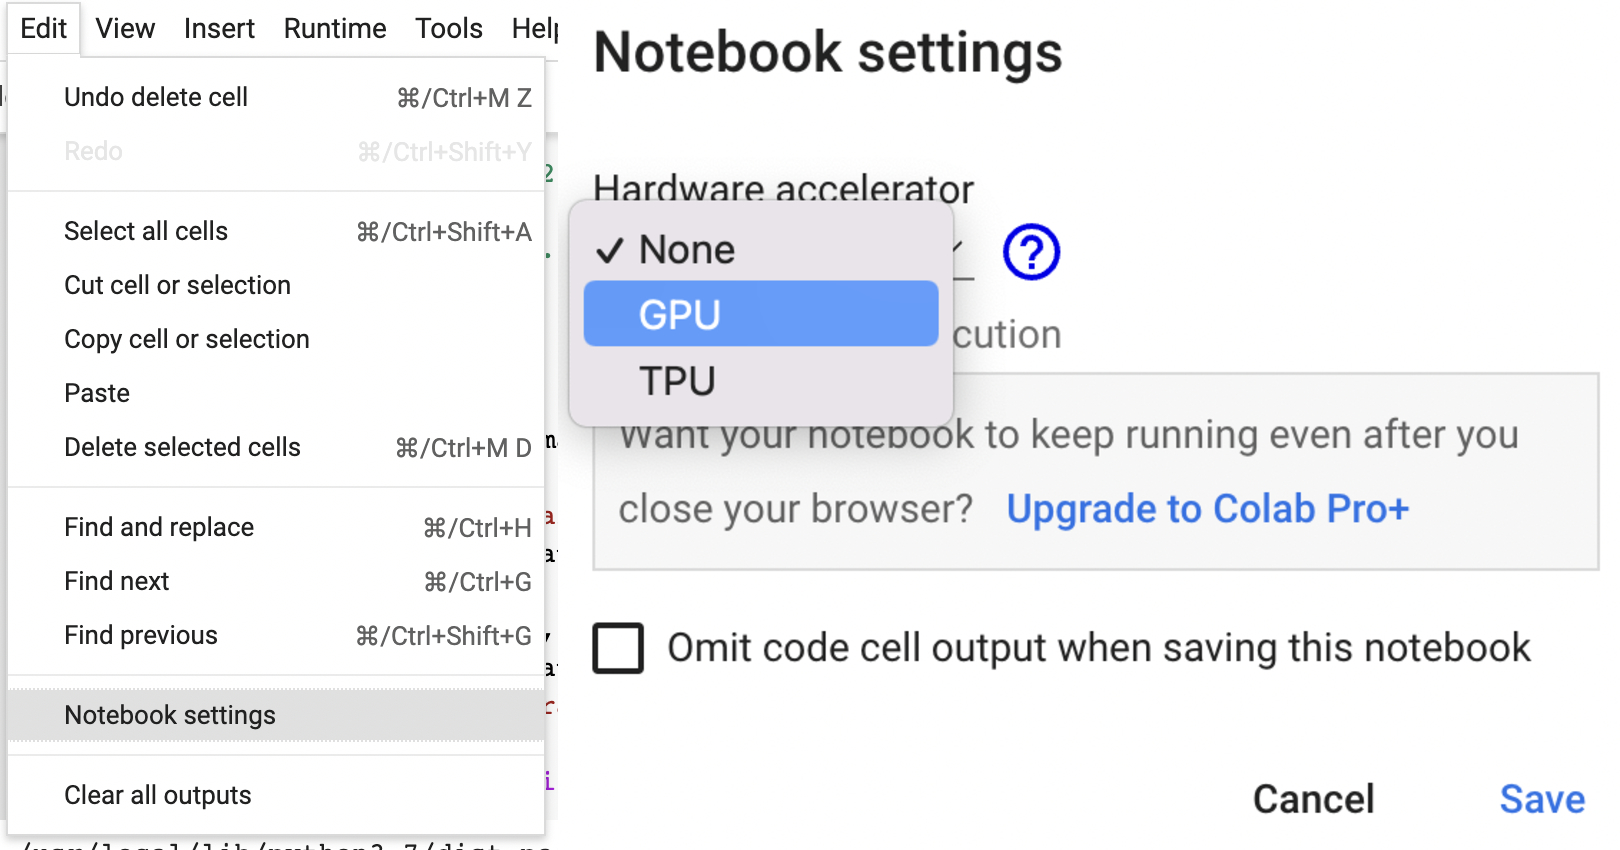

If `device` is equal to `cuda`, it means GPU has been enabled successfully. 

In [49]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Copying this Colab to your Google Drive ⚠️ 

Since we're the author of this Colab, you cannot make any changes to it. You must copy it to your Google Drive by clicking on **Copy to Drive**. If you don't do this, none of your progress will be saved.

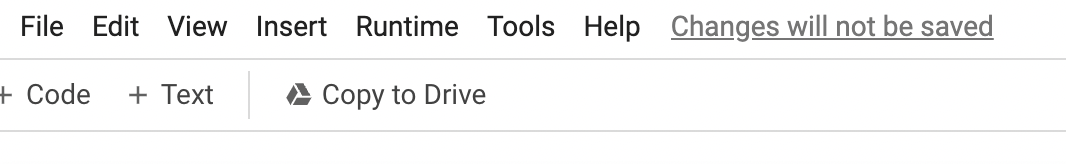

##  Assignment Introduction ℹ️

This assignment will give you practice using the library PyTorch, which is a popular library for constructing deep learning models. Deep Learning is a very powerful tool because it is able to learn very complicated functions. Deep Learning has revolutionized fields like image and speech recognition. 

The specific task we are trying to solve in this assignment is image classification. We will be using a very commong dataset called CIFAR-10 that has 60,000 images separated into 10 classes. The classes are 
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

In this assignment, you will practice:
* Reading documentation for a modern machine learning library
* Writing PyTorch code. 
* Evaluating neural network models.
* Understand how to improve the performance of an image classification model.
_______________________
Fill in the cells provided marked `TODO` with code to answer the questions.

**Make sure to restart the kernel and run all cells** (especially before turning it in) to make sure your code runs correctly. **Note this assignment takes a long time to run so make sure to do this earlier than later**.

Unlike other assignments, **this assignment will not be autograded**. We won't assignment partial credit for each part, so please make sure to check your implementations carefully.

> Copyright ©2022 Hunter Schafer and Pemi Nguyen.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2022 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.


# Step 1 - Background Reading 📖

Before starting this assignment, you should familiarize yourself with PyTorch. You should read [their tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and preferably follow along with a Colab notebook. You should only have to fully read the sections:
* "What is PyTorch?"
* *Optional* "Autograd: Automatic Differentiation"
* "Neural Networks"
* "Training a Classifier"

This should take about an hour (according to the name of the tutorial). Once you are done with that, you should be more ready to tackle this assignment! 

You will probably also want to look at the [documentation](https://pytorch.org/docs/stable/index.html) to understand what parameters they are specifying in the tutorial.

In [50]:
import math 

import matplotlib.pyplot as plt              # For plotting
import seaborn as sns                        # For styling plots
import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data

sns.set()
torch.manual_seed(0)

Then we define some constants that will be used throughout the program. Note that the `SAMPLE_DATA`
constant is a flag for helping speed up the development of this assignment by only using a subset
of the data while training. As it will take a long time (> 15 minutes) to train all of the models on
the whole dataset, we recommend setting this flag to `True` while you are developing the assignment
to get more rapid feedback on if your code can run. **Make sure to set the flag to `False` and 
run all of your code before you submit!**

In [51]:
INPUT_SIZE    = 3 * 32 * 32   # An image has 32 x 32 pixels each with Red/Green/Blue values. 
NUM_CLASSES   = 10            # The number of output classes. In this case, from 0 to 9
BATCH_SIZE    = 100           # The size of input data took for one iteration of an epoch
SAMPLE_DATA   = False         # A flag that controls if we should make the dataset smaller
                              # for faster training time when developing a solution. 
                              # ⚠️ ENSURE THIS FLAG IS FALSE AND YOU RERUN ALL CELLS BEFORE YOU SUBMIT

The first step is to download the dataset using PyTorch. The code below produces a train set and a validation set. Some notes on PyTorch terminology:
* Most of the time we use the `train_loader` instead of the `trainset`. The reason being the loader gives us batches of examples from the entire `trainset`. Looping over the `train_loader` returns a subset of the examples on each iteration.
* PyTorch commonly talks about "tensors". For our purposes, a tensor is just a multi-dimensional array. For example, the `trainset` is a tensor with shape `(50000, 32, 32, 3)` because there are 50,000 images, each is 32x32 pixels with 3 color channels (Red/Green/Blue). You can index into these just like `numpy` arrays.
* We pre-process the data into tensors and the normalize them so all the pixels have mean 0.5 and standard devaition 0.5.


In [52]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

if SAMPLE_DATA:  # Make sure this is False and you rerun all cells before you submit!
    # Only grab a subset of the data to speed up training time while developing a solution
    trainset, _ = torch.utils.data.random_split(trainset, [BATCH_SIZE * 10, len(trainset) - BATCH_SIZE * 10])
    valset, _ = torch.utils.data.random_split(valset, [BATCH_SIZE * 10, len(valset) - BATCH_SIZE * 10])


train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

----
In the cell below, we define the critical helper functions to train and visualize the results of the neural networks. You should read and understand what they are doing.

In [54]:
def train(net, train_loader, val_loader, 
          num_epochs, learning_rate, 
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs. 
    If compute_accs is true, evaluates the train and val accuracy of the network at the end of 
    each epoch.

    Args:
        net: The neural network to train
        train_loader, val_loader: The pytorch dataset loaders for the trainset and valset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and val
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and val accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer 
    # (algorithm like gradient descent). Here we use a common loss function for multi-class 
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    val_accs = []
    best_val_acc = 0

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            
            images = images.to(device)
            labels = labels.to(device)

    
            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes

            if batch_num % 100 == 0:  # Print every 100 batches                              
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            
            batch_num += 1

        if compute_accs:
            train_acc = accuracy(net, train_loader) 
            val_acc = accuracy(net, val_loader) 
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            best_val_acc = max(best_val_acc, val_acc)
            print(f'Epoch [{epoch}/{num_epochs}], Train Accuracy {100 * train_acc:.2f}%, Validation Accuracy {100 * val_acc:.2f}%')
            print(f'Best Validation Accuracy {100 * best_val_acc:.2f}%')
    
    if compute_accs:
        return train_accs, val_accs, best_val_acc


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification 
    accuracy. 

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count
        
    return correct / total
    

def plot_history(histories):
    """
    Given a series of training/validation accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained. 
                   Each dictionary should have the keys:
                        * name: The model name
                        * train_accs: A list of train accuracies 
                        * val_accs: A list of val accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['val_accs'],
                     '--', label=model_history['name'] + ' Validation')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=model_history['name'] + ' Train')
  
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])

## Step 2: Defining model architectures 🏛️
We are going to actually write the PyTorch code that specifies the neural network models. Each of the models described should be a different Python class with the specified name.

### Prob 0) `NetExample`

We're giving you an example neural network. This one will be the simplest in that it has no hidden layers (so this is technically logistic regression). It takes the image and flattens it to a vector for the input, and then has 10 outputs, one for each class. There are no non-linearities for this network and is just a very simple linear classifier.

In [55]:
class NetExample(nn.Module):
    def __init__(self):
        super(NetExample, self).__init__()
        # Define the layers in the __init__ method, and use the layers 
        # in the forward method.
        self.lin = nn.Linear(INPUT_SIZE, NUM_CLASSES)

    def forward(self, x):
        x = x.view(-1, INPUT_SIZE) # Flatten the image into a vector
        x = self.lin(x) # Pass the image into a fully connected layer
        return x


### Prob 1) `NetA`

(4 points) The first neural network you have to implement will be slightly more complicated in that it has a hidden layer with 300 nodes and adds a non-linearity between the layers. It should use the following operations in this order:
* Flatten the image to a vector for the input
* Use a fully-connected linear layer with 300 hidden-neurons followed by a ReLU activation function
* Use a fully-connected linear layer to the 10 outputs.

In [56]:
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        self.fcA1 = nn.Linear(INPUT_SIZE, 300)
        self.fcA2 = nn.Linear(300, NUM_CLASSES)

    def forward(self, x):
        x = x.view(-1, INPUT_SIZE)
        x = F.relu(self.fcA1(x))
        x = self.fcA2(x)
        return x

### Prob 2) `NetB`

(6 points) The second neural network will be slightly deeper than the first one in that it has two hidden layers.
* Flatten the image to a vector for the input
* Use a fully-connected linear layer with 100 hidden-neurons followed by a ReLU activation function
* Use a fully-connected linear layer with 60 hidden-neurons followed by a ReLU activation function
* Use a fully-connected linear layer to the 10 outputs.

In [57]:
class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        self.fcB1 = nn.Linear(INPUT_SIZE, 100)
        self.fcB2 = nn.Linear(100, 60)
        self.fcB3 = nn.Linear(60, NUM_CLASSES)

    def forward(self, x):
        x = x.view(-1, INPUT_SIZE)
        x = F.relu(self.fcB1(x))
        x = F.relu(self.fcB2(x))
        x = self.fcB3(x)
        return x

### Prob 3) `NetC`

(15 points) This third neural network will be a convolutional neural network. It should use the following operations in this order: 
* Use a convolution layer with kernel-width 5 and depth 25 (note: **zero padding** and **stride = 1** are by default in `nn.Conv2d`) 
* Use the ReLU activation function
* Use a max-pool operation with kernel-width 2 and stride 2
* Reshape the image to a vector for the next step's input using `.view()`.
* Use a fully-connected linear layer to the 10 outputs.

This architecture can be seen visually in the following diagram (the left-most object is the input image). 

![Network Architecture](https://courses.cs.washington.edu/courses/cse416/19su/files/assignment-resources/homework/hw7/nn.svg)

Notice that these diagrams use the following notation to describe the dimensions of the results at each step.
```
channels @ height x width
``` 

In [58]:
class NetC(nn.Module):
    def __init__(self,):
        super(NetC, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=25, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(25*14*14, NUM_CLASSES)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 25*14*14)
        x = self.fc(x)
        
        return x

### Prob 4) `NetD`

(10 points) This is your chance to try out some different architectures of your choice. Create your own neural network architecture that has **at least 2 convolution layers** and **at least 2 fully connected layers**. Your goal is to pick a network architecture that achieves **at least 65% validation accuracy**. Most of the points for this problem are based on having a model that meets the minimum layer requirements, with fewer points focusing on the accuracy.

*Implementation details/notes*:
* Every convolution operation should be followed by a pooling operation. 
* Every linear layer and convolution layer should have an activation function. However, it is common to not have one on the very last layer to the 10 outputs (unless it is softmax) so you do not need one there.
* You will likely want to use `NetC` as a starting point!  

In [59]:
class NetD(nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=25, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=25, out_channels=100, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(100*5*5, 1000)
        self.fc2 = nn.Linear(1000, NUM_CLASSES)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 100*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

### Extra Credit (**Optional**): `NetE` 

*Note: Recall our extra credit policy states that extra credit will not be a major influence on your grade, but may be used for minor adjustments for students who are close to a cutoff. They are usually not worth the time it takes to do them compared to the regular points for the course.*

This is your last chance to improve the performance of a neural network model by applying some regularization methods. As you are already aware, overfitting is a common issue in neural networks. You're going to include **Batch Normalization** and/or **Dropout** layers in the architecture of `NetD` to increase its validation accuracy. Your goal is to create a network architecture that achieves **at least 70% validation accuracy**.

*Implementation details/notes*:
* You will use `NetD` architecture as a baseline.
* To use batch normalization, you can create `nn.BatchNorm1D` layer (after a fully connected layer) or `nn.BatchNorm2D` layer (after a convolutional / maxpool layer), whose only parameter is the input size, such as `nn.BatchNorm2d(25)`.
* To use dropout, you can create `nn.Dropout` layer (after a fully connected layer) or `nn.Dropout2D` layer (after a convolutional / maxpool layer), whose only parameter is a probability, such as `nn.Dropout(0.2)`.
* You don't have to use both batch normalization and dropout. You're only expected to apply **at least one layer** so that the target validation accuracy is reached.
________

* *Optional*: The intuition behind Batch Normalization is that through a lot of layers in a neural networks, inputs to each layer will be distributed on a wide range of values. It is hypothesized that values with widely varying magnitude can affect the convergence of a neural network. Batch normalization is a technique to standardize the inputs to layers in a neural network.
* *Optional*: The intuition behind dropout is that in a neural network, neurons between every two layers shared lots of weights with each other, so there is a strongly co-dependency among them which potentially leads to overfitting. Dropout is a technique where randomly selected neurons are ignored during training (they are “dropped-out” randomly). This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

In [60]:
class NetE(nn.Module):
    def __init__(self):
        super(NetE, self).__init__()
        # TODO

    def forward(self, x):
        # TODO
        return x

# Step 3 - Training and validating models

Below are the cells that run the training and validation of the above 5 models. We specified 10 epochs and a learning rate of 0.001 for each model, but you're welcome to fine-tune these hyperparameters.

While doing the homework, you can skip the cells for some networks to avoid re-running them if the code is already correct. However, when submitting the notebook, the printed outputs for training and validation for each model must be shown in order for you to receive full credit. 

As a result, it's recommended that before you turn in, you should run all the cells from the beginning. There are no benchmark accuracies for `NetA`, `NetB` and `NetC`, but we must see that `NetD` has reached 65% best validation accuracy in order for you to receive full credit.

### 1. `NetA`

==== Training NetA ====
Epoch [1/10], Step [100/500], Loss: 1.8410
Epoch [1/10], Step [200/500], Loss: 1.5857
Epoch [1/10], Step [300/500], Loss: 1.3770
Epoch [1/10], Step [400/500], Loss: 1.5844
Epoch [1/10], Step [500/500], Loss: 1.3344
Epoch [1/10], Train Accuracy 48.59%, Validation Accuracy 45.68%
Best Validation Accuracy 45.68%
Epoch [2/10], Step [100/500], Loss: 1.4966
Epoch [2/10], Step [200/500], Loss: 1.6069
Epoch [2/10], Step [300/500], Loss: 1.5818
Epoch [2/10], Step [400/500], Loss: 1.3402
Epoch [2/10], Step [500/500], Loss: 1.3968
Epoch [2/10], Train Accuracy 54.43%, Validation Accuracy 49.81%
Best Validation Accuracy 49.81%
Epoch [3/10], Step [100/500], Loss: 1.3558
Epoch [3/10], Step [200/500], Loss: 1.5640
Epoch [3/10], Step [300/500], Loss: 1.2164
Epoch [3/10], Step [400/500], Loss: 1.4084
Epoch [3/10], Step [500/500], Loss: 1.1755
Epoch [3/10], Train Accuracy 56.84%, Validation Accuracy 50.16%
Best Validation Accuracy 50.16%
Epoch [4/10], Step [100/500], Loss: 1.2445


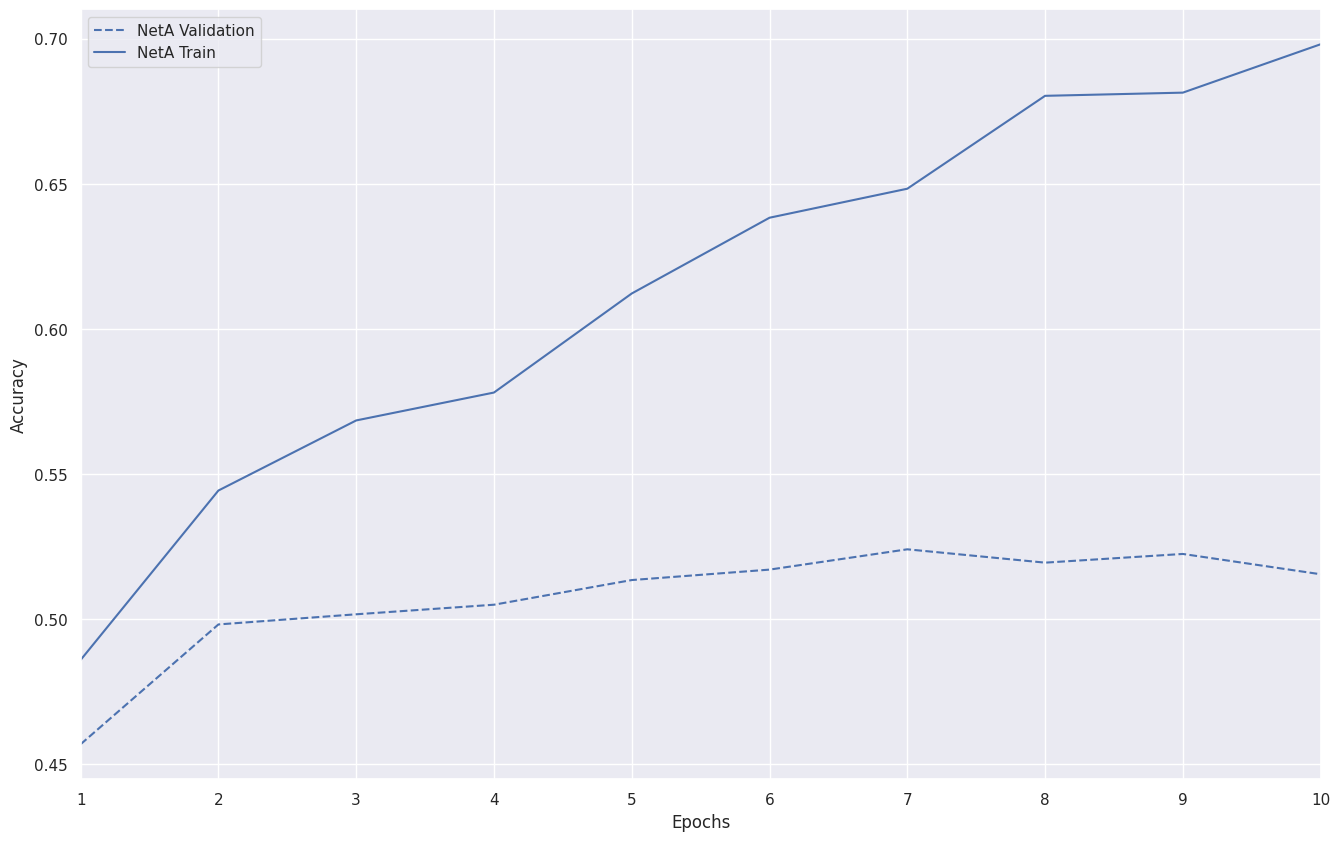

In [61]:
histories_A = []

netA = NetA()
print(f'==== Training NetA ====')
netA.to(device)
train_history_A, val_history_A, _ = train(netA, train_loader, val_loader, 
    num_epochs=10, learning_rate=1e-3, compute_accs=True)
histories_A.append({
      'name': 'NetA', 
      'train_accs': train_history_A, 
      'val_accs': val_history_A
})
plot_history(histories_A)

### 2. `NetB`

==== Training NetB ====
Epoch [1/10], Step [100/500], Loss: 1.8605
Epoch [1/10], Step [200/500], Loss: 1.6154
Epoch [1/10], Step [300/500], Loss: 1.6585
Epoch [1/10], Step [400/500], Loss: 1.5012
Epoch [1/10], Step [500/500], Loss: 1.4054
Epoch [1/10], Train Accuracy 47.62%, Validation Accuracy 46.36%
Best Validation Accuracy 46.36%
Epoch [2/10], Step [100/500], Loss: 1.5803
Epoch [2/10], Step [200/500], Loss: 1.4518
Epoch [2/10], Step [300/500], Loss: 1.4895
Epoch [2/10], Step [400/500], Loss: 1.6605
Epoch [2/10], Step [500/500], Loss: 1.2959
Epoch [2/10], Train Accuracy 50.79%, Validation Accuracy 47.85%
Best Validation Accuracy 47.85%
Epoch [3/10], Step [100/500], Loss: 1.4071
Epoch [3/10], Step [200/500], Loss: 1.3140
Epoch [3/10], Step [300/500], Loss: 1.3460
Epoch [3/10], Step [400/500], Loss: 1.5315
Epoch [3/10], Step [500/500], Loss: 1.1964
Epoch [3/10], Train Accuracy 54.50%, Validation Accuracy 49.66%
Best Validation Accuracy 49.66%
Epoch [4/10], Step [100/500], Loss: 1.4326


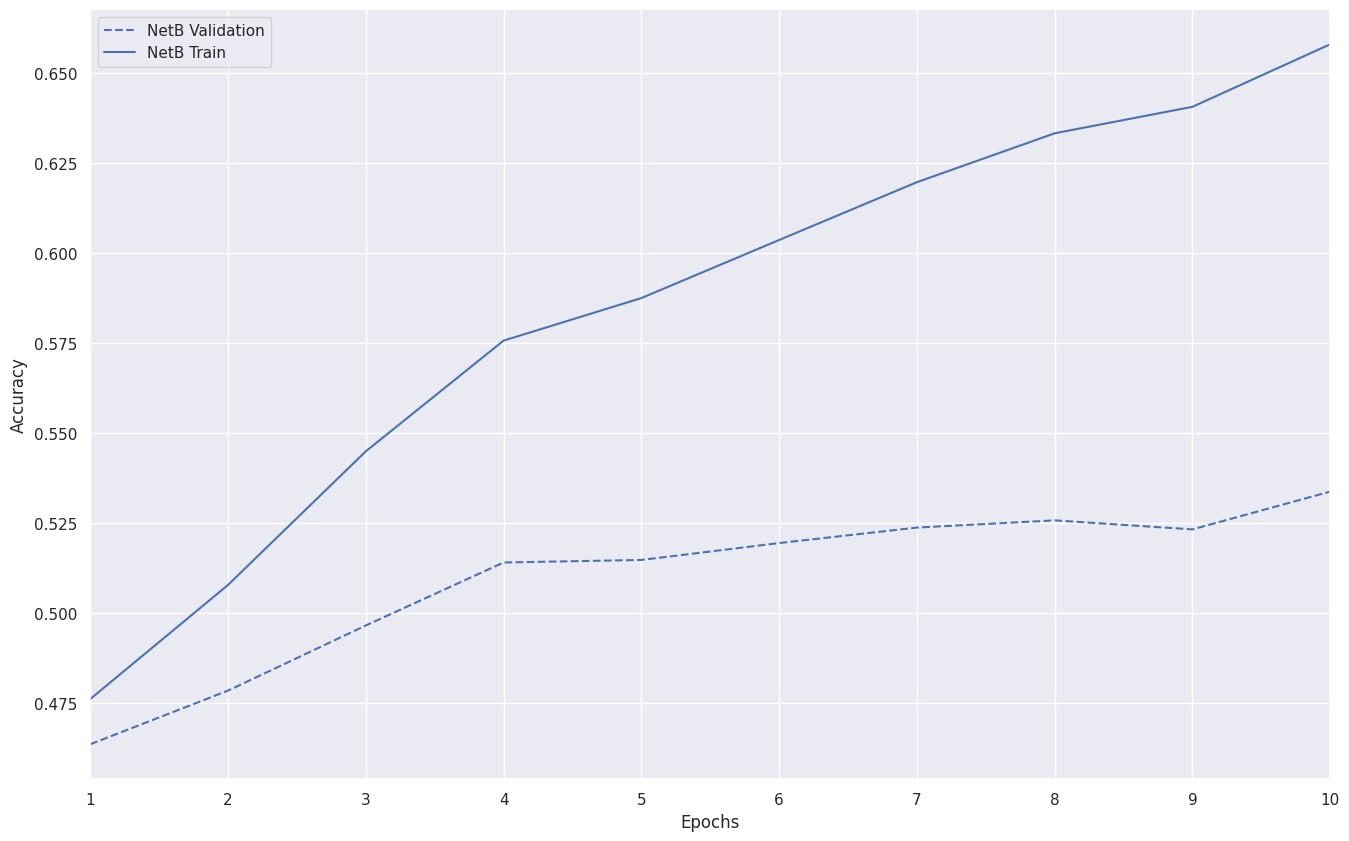

In [62]:
histories_B = []

netB = NetB()
print(f'==== Training NetB ====')
netB.to(device)
train_history_B, val_history_B, _ = train(netB, train_loader, val_loader, 
        num_epochs=10, learning_rate=1e-3, compute_accs=True)
histories_B.append({
      'name': 'NetB', 
      'train_accs': train_history_B, 
      'val_accs': val_history_B
})
plot_history(histories_B)

### 3. `NetC`

==== Training NetC ====
Epoch [1/10], Step [100/500], Loss: 1.6352
Epoch [1/10], Step [200/500], Loss: 1.3936
Epoch [1/10], Step [300/500], Loss: 1.2397
Epoch [1/10], Step [400/500], Loss: 1.3771
Epoch [1/10], Step [500/500], Loss: 1.2252
Epoch [1/10], Train Accuracy 54.51%, Validation Accuracy 52.44%
Best Validation Accuracy 52.44%
Epoch [2/10], Step [100/500], Loss: 1.3422
Epoch [2/10], Step [200/500], Loss: 1.1265
Epoch [2/10], Step [300/500], Loss: 1.2354
Epoch [2/10], Step [400/500], Loss: 1.2083
Epoch [2/10], Step [500/500], Loss: 0.9460
Epoch [2/10], Train Accuracy 63.05%, Validation Accuracy 59.55%
Best Validation Accuracy 59.55%
Epoch [3/10], Step [100/500], Loss: 1.0227
Epoch [3/10], Step [200/500], Loss: 1.0570
Epoch [3/10], Step [300/500], Loss: 0.9876
Epoch [3/10], Step [400/500], Loss: 0.9921
Epoch [3/10], Step [500/500], Loss: 0.9379
Epoch [3/10], Train Accuracy 66.18%, Validation Accuracy 62.22%
Best Validation Accuracy 62.22%
Epoch [4/10], Step [100/500], Loss: 0.9725


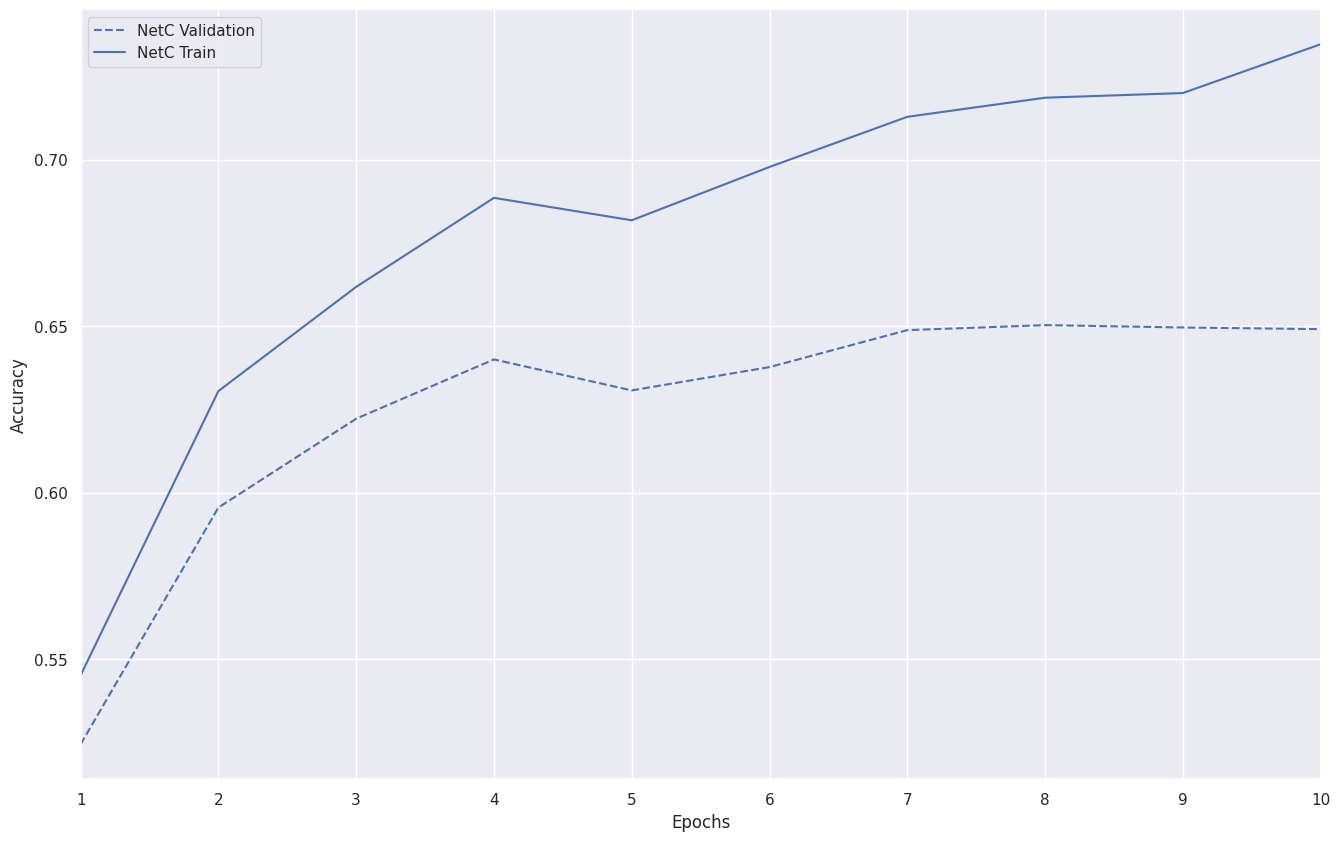

In [63]:
histories_C = []

netC = NetC()
print(f'==== Training NetC ====')
netC.to(device)
train_history_C, val_history_C, _ = train(netC, train_loader, val_loader, 
        num_epochs=10, learning_rate=1e-3, compute_accs=True)
histories_C.append({
      'name': 'NetC', 
      'train_accs': train_history_C, 
      'val_accs': val_history_C
})
plot_history(histories_C)

### 4. `NetD`

==== Training NetD ====
Epoch [1/10], Step [100/500], Loss: 1.4113
Epoch [1/10], Step [200/500], Loss: 1.2452
Epoch [1/10], Step [300/500], Loss: 1.3025
Epoch [1/10], Step [400/500], Loss: 1.4053
Epoch [1/10], Step [500/500], Loss: 1.0099
Epoch [1/10], Train Accuracy 60.49%, Validation Accuracy 58.61%
Best Validation Accuracy 58.61%
Epoch [2/10], Step [100/500], Loss: 0.9814
Epoch [2/10], Step [200/500], Loss: 0.9699
Epoch [2/10], Step [300/500], Loss: 1.1084
Epoch [2/10], Step [400/500], Loss: 0.9486
Epoch [2/10], Step [500/500], Loss: 0.8618
Epoch [2/10], Train Accuracy 71.60%, Validation Accuracy 66.85%
Best Validation Accuracy 66.85%
Epoch [3/10], Step [100/500], Loss: 0.7676
Epoch [3/10], Step [200/500], Loss: 0.7275
Epoch [3/10], Step [300/500], Loss: 0.8454
Epoch [3/10], Step [400/500], Loss: 0.8725
Epoch [3/10], Step [500/500], Loss: 0.6880
Epoch [3/10], Train Accuracy 79.45%, Validation Accuracy 71.78%
Best Validation Accuracy 71.78%
Epoch [4/10], Step [100/500], Loss: 0.5355


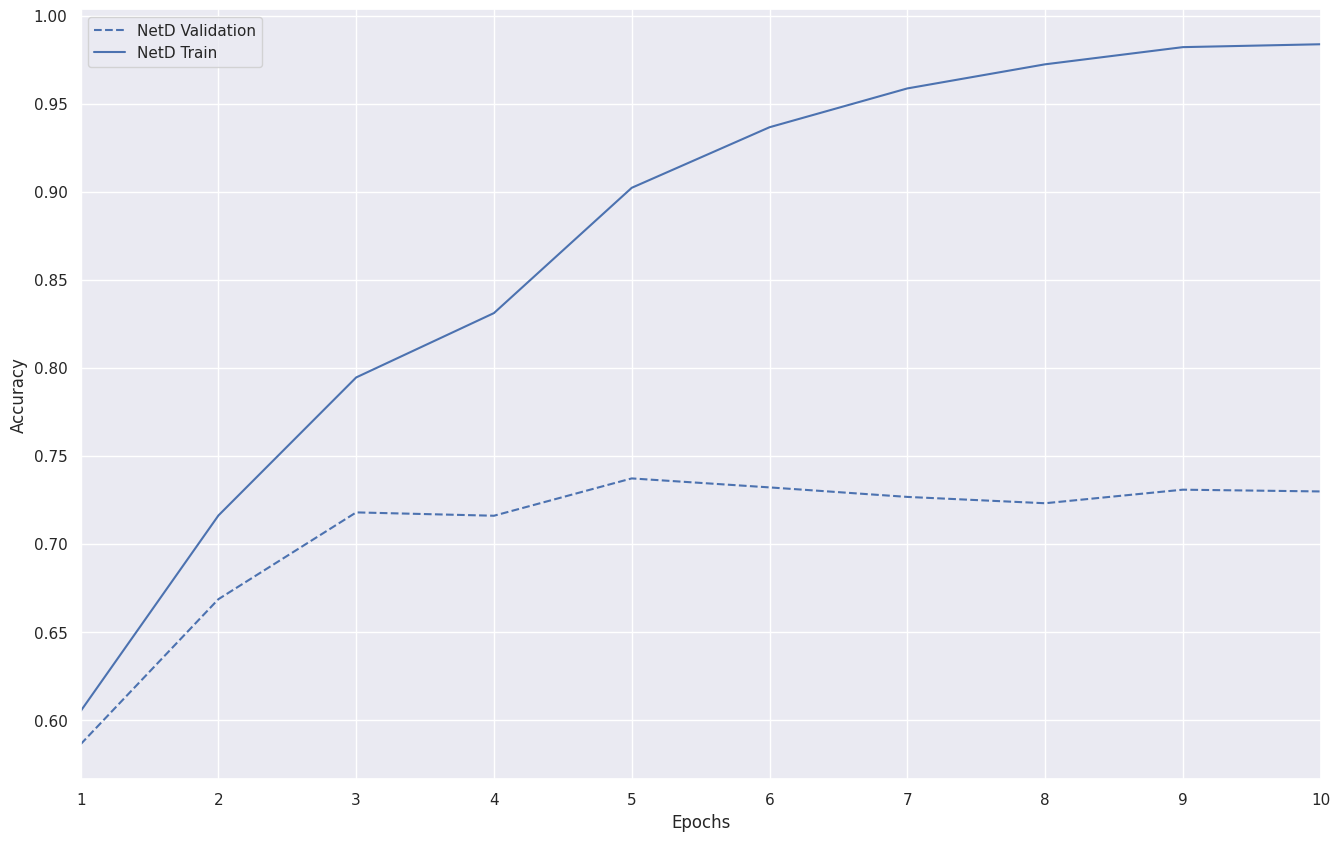

In [64]:
histories_D = []

netD = NetD()
print(f'==== Training NetD ====')
netD.to(device)
train_history_D, val_history_D, _ = train(netD, train_loader, val_loader, 
        num_epochs=10, learning_rate=1e-3, compute_accs=True)
histories_D.append({
      'name': 'NetD', 
      'train_accs': train_history_D, 
      'val_accs': val_history_D
})
plot_history(histories_D)

### 5. **Extra Credit (Optional)**: `NetE`

Uncomment the below lines if you are trying the extra credit.

In [65]:
# histories_E = []

# netE = NetE()
# print(f'==== Training NetE ====')
# netE.to(device)
# train_history_E, val_history_E, _ = train(netE, train_loader, val_loader, 
#       num_epochs=10, learning_rate=1e-3, compute_accs=True)
# histories_E.append({
#       'name': 'NetE', 
#       'train_accs': train_history_E, 
#       'val_accs': val_history_E
# })
# plot_history(histories_E)

## All Networks

The following plot uses all of the histories to compare performances across models. 

If you did the extra credit, add the histories for `NetE` to the plot as well to compare.

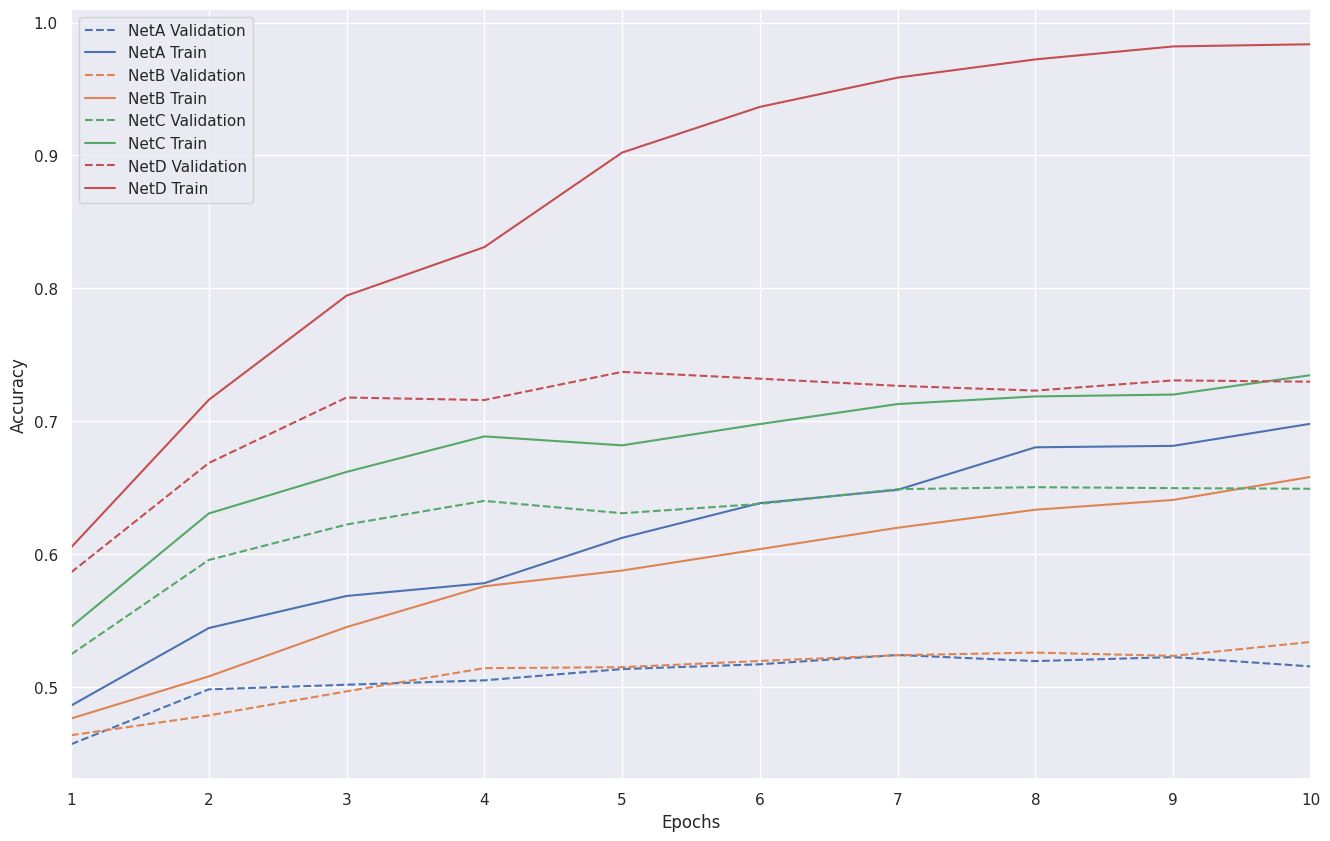

In [66]:
all_histories = histories_A + histories_B + histories_C + histories_D
plot_history(all_histories)

# Before you submit
Make sure you have undone any changes to the starter code that impact model training you were not asked to change. Specifically look for the development tips we suggested to undo those changes
* Training neural networks model is time-consuming. Allocate proper time for doing so.
* Make sure your models are trained on the whole dataset by setting the `SAMPLE_DATA` flag to `False`. Together, the 4 models should take about 16 minutes to train if you are using the whole dataset.
* Make sure you are training all 4 of `NetA`, `NetB`, `NetC`, and `NetD`. Your final plot should show these 4 models' training/validation accuracies during over the training and validation phase (5 if you did the extra credit and include `NetE`).
* Make sure you have run all the cells and the graphs appear in your notebook. For grading, we need to see the desired output in your notebook. If your notebook does not produce the desired output, we will not award high marks.

# To Submit
Download the notebook from Colab as a `.ipynb` notebook (`File > Download > Download .ipynb`) and upload it on Gradescope.